In [264]:
import os
import sys
import re
import shutil
import time
import pickle
import requests
import seaborn as sns
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set()

from fbprophet import Prophet

from solution_guidance.cslib import fetch_data

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


from functools import partial
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from sklearn.preprocessing import StandardScaler, scale
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import xgboost as xgb
from statsmodels.tsa.stattools import pacf, acf

import warnings
warnings.filterwarnings("ignore")

## PART 3 - Data Preparation

In [26]:
def load_data():
    
    DIR = os.getcwd()
    data_dir = os.path.join(".", "data")
    df = fetch_data(os.path.join(data_dir,'cs-train'))
    
    return df

def get_preprocessor(df):
    """
    return the preprocessing pipeline
    """

    ## preprocessing pipeline
    df['invoice'] = df['invoice'].str.replace(r"[a-zA-Z]",'').astype('int')
    
#     numeric_features = []
#     numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
#                                           ('scaler', StandardScaler())])

#     categorical_features = []
#     categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#                                               ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#     preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
#                                                    ('cat', categorical_transformer, categorical_features)])
    return df

def prepare_timeseries(df):
    """
    prepare time series data
    """
    
    # revenue time series data
    ts_rev = df[['invoice_date', 'country', 'price']].set_index('invoice_date')
    ts_rev_day = pd.DataFrame(ts_rev.groupby('country').resample('D')['price'].sum())
    #ts_rev_day = ts_rev.resample('D').sum() 
    ts_rev_day = ts_rev_day.reset_index()
    ts_rev_day.columns = ['country','ds', 'y']
    #ts_rev_day.columns = ['ds', 'y']

    # times_viewed time series data
    ts_tv = df[['invoice_date', 'country' ,'times_viewed']].set_index('invoice_date')
    ts_tv_day = pd.DataFrame(ts_tv.groupby('country').resample('D')['times_viewed'].sum())
    #ts_tv_day = ts_tv.resample('D').sum() 
    ts_tv_day = ts_tv_day.reset_index()
    ts_tv_day.columns = ['country','ds', 'y']
    #ts_tv_day.columns = ['ds', 'y']
    
    # prepare the data for the model
    ts1 = ts_rev_day.set_index('ds')
    ts1['y'] = ts1['y'].replace(0.00, ts1['y'].mean())  # replacing 0.00 values with mean in the ts data
    ts2 = ts_tv_day.set_index('ds')
    ts2['y'] = ts2['y'].replace(0.00, ts2['y'].mean())  # replacing 0.00 values with mean in the ts data
    ts3 = pd.concat([ts1,ts2], axis=1 )
    ts3.columns = ['country1','revenue', 'country1', 'times_viewed'] 
    #ts3.columns = ['revenue', 'times_viewed'] 
    ts3.columns = ts3.columns.str.strip()

    return ts1, ts2

# MAPE computation
def mape(y, yhat, perc=True):
    n = len(yhat.index) if type(yhat) == pd.Series else len(yhat)    
    mape = []
    for a, f in zip(y, yhat):
        # avoid division by 0
        if f > 1e-9:
            mape.append(np.abs((a - f)/a))
    mape = np.mean(np.array(mape))
    return mape * 100. if perc else mape

mape_scorer = make_scorer(mape, greater_is_better=False)

class TargetTransformer:
    """
    Perform some transformation on the time series
    data in order to make the model more performant and
    avoid non-stationary effects.
    """
        
    def __init__(self, log=False, detrend=False, diff=False):
        
        self.trf_log = log
        self.trf_detrend = detrend
        self.trend = pd.Series(dtype=np.float64)
    
    def transform(self, index, values):
        """
        Perform log transformation to the target time series

        :param index: the index for the resulting series
        :param values: the values of the initial series

        Return:
            transformed pd.Series
        """
        res = pd.Series(index=index, data=values)

        if self.trf_detrend:
            self.trend = TargetTransformer.get_trend(res) - np.mean(res.values)
            res = res.subtract(self.trend)
            
        if self.trf_log:
            res = pd.Series(index=index, data=np.log(res.values))
        
        return res
    
    def inverse(self, index, values):
        """
        Go back to the original time series values

        :param index: the index for the resulting series
        :param values: the values of series to be transformed back

        Return:
            inverse transformed pd.Series
        """        
        res = pd.Series(index=index, data=values)
        
        if self.trf_log:
            res = pd.Series(index=index, data=np.exp(values))
        try:
            if self.trf_detrend:
                assert len(res.index) == len(self.trend.index)                
                res = res + self.trend
                
        except AssertionError:
            print("Use a different transformer for each target to transform")
            
        return res
    
    @staticmethod
    def get_trend(data):
        """
        Get the linear trend on the data which makes the time
        series not stationary
        """
        n = len(data.index)
        X = np.reshape(np.arange(0, n), (n, 1))
        y = np.array(data)
        model = LinearRegression()
        model.fit(X, y)
        trend = model.predict(X)
        return pd.Series(index=data.index, data=trend)

df = load_data()
df_processed = get_preprocessor(df)
ts1, ts2 = prepare_timeseries(df_processed)

### XGBoost Method - Revenue

In [173]:
# dictionary to keep track of all results
forecasting_results = {
    "linear_revenue" : {},
    "linear_times_viewed" : {},
    "xgb_revenue" : {},
    "xgb_times_viewed": {}
}

In [174]:
country = input ("Enter country name, i.e. Australia, to forecast all countries, leave blank and press Enter: ")  
date_input = input("Enter data between 2019-07-30 to 2019-08-28 i.e. 2019-08-01 : ")
date_input = datetime.strptime(date_input, '%Y-%m-%d')

Enter country name, i.e. Australia, to forecast all countries, leave blank and press Enter: 
Enter data between 2019-07-30 to 2019-08-28 i.e. 2019-08-01 : 2019-08-01


In [175]:
if country != '' :
    model_data = ts1[ts1['country'] == country]
elif country == '' :
    model_data = ts1.resample('D').sum() 

In [177]:
# 1 day forecast
FCAST_STEPS = 30
# seasonal period inferred from the autocorrelation function
SEASONAL_PERIOD = 5

# the complete time series
c_target = model_data["y"]

# data used for training
date = c_target.index[-1] - pd.Timedelta(hours=FCAST_STEPS)
t_target = c_target[c_target.index <= date]

# data used for forecasting
f_target = c_target[c_target.index > date]
fcast_initial_date = f_target.index[0]
fcast_range = pd.date_range(fcast_initial_date, periods=FCAST_STEPS, freq="D")

print(f"Full available time range: from {c_target.index[0]} to {c_target.index[-1]}")
print(f"Training time range: from {t_target.index[0]} to {t_target.index[-1]}")
print(f"Short forecasting time range: from {fcast_range[0]} to {fcast_range[-1]}")

Full available time range: from 2017-11-28 00:00:00 to 2019-07-31 00:00:00
Training time range: from 2017-11-28 00:00:00 to 2019-07-29 00:00:00
Short forecasting time range: from 2019-07-30 00:00:00 to 2019-08-28 00:00:00


### XGB Method and Revenue Recursive Forecasting

In [178]:
def optimal_lag_features_threshold(target, lags=None):
    
    if lags is None:
        partial = pd.Series(data=pacf(target, nlags=48))
        partial_abs = np.abs(partial)
        opt_thres = np.abs(partial_abs[1:]).median()
        
    return opt_thres

def create_lag_features(target, lags=None, thres=0.2):
    
    scaler = StandardScaler()
    features = pd.DataFrame()
                
    if lags is None:
        partial = pd.Series(data=pacf(target, nlags=48))
        lags = list(partial[np.abs(partial) >= thres].index)

    df = pd.DataFrame()
    if 0 in lags:
        lags.remove(0) # do not consider itself as lag feature
    for l in lags:
        df[f"lag_{l}"] = target.shift(l)
        
    features = pd.DataFrame(scaler.fit_transform(df[df.columns]), 
                            columns=df.columns)

    features = df
    features.index = target.index
    
    return features

def create_ts_features(data):
    
    def get_shift(row):
        """
        Factory working shift: 3 shifts per day of 8 hours
        """
        if 6 <= row.hour <= 14:
            return 2
        elif 15 <= row.hour <= 22:
            return 3
        else:
            return 1
    
    features = pd.DataFrame()
    
    features["hour"] = data.index.hour
    features["weekday"] = data.index.week
    features["dayofyear"] = data.index.dayofyear
    features["is_weekend"] = data.index.weekday.isin([5, 6]).astype(np.int32)
    features["weekofyear"] = data.index.weekofyear
    features["month"] = data.index.month
    features["season"] = (data.index.month%12 + 3)//3
    features["shift"] = pd.Series(data.index.map(get_shift))
    
    features.index = data.index
        
    return features

opt_thres = optimal_lag_features_threshold(t_target, lags=None)
lags = create_lag_features(t_target, thres=opt_thres)
ts = create_ts_features(t_target)
features = ts.join(lags, how="outer").dropna()
target = t_target[t_target.index >= features.index[0]]
features.head()

,hour,weekday,dayofyear,is_weekend,weekofyear,month,season,shift,lag_1,lag_2,...,lag_27,lag_28,lag_29,lag_30,lag_32,lag_35,lag_37,lag_38,lag_42,lag_48
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-15,0,3,15,0,3,1,1,1,8413.801291,5191.816999,...,18109.265583,7173.094166,6291.304166,5191.816999,11811.768458,23977.168458,4759.165583,9008.508458,15517.082791,14450.540000
2018-01-16,0,3,16,0,3,1,1,1,13451.169874,8413.801291,...,6811.149874,18109.265583,7173.094166,6291.304166,14864.422749,14338.644166,8876.732749,4759.165583,12062.918500,14493.588542
2018-01-17,0,3,17,0,3,1,1,1,11957.879458,13451.169874,...,5191.816999,6811.149874,18109.265583,7173.094166,5191.816999,19773.522749,23977.168458,8876.732749,15162.402749,15020.855666
2018-01-18,0,3,18,0,3,1,1,1,11781.075583,11957.879458,...,5191.816999,5191.816999,6811.149874,18109.265583,6291.304166,11811.768458,14338.644166,23977.168458,14437.811333,11850.537083
2018-01-19,0,3,19,0,3,1,1,1,8397.439874,11781.075583,...,5191.816999,5191.816999,5191.816999,6811.149874,7173.094166,14864.422749,19773.522749,14338.644166,9008.508458,4688.145625


In [179]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.3,
                                                    shuffle=False) 

y_train_trf = TargetTransformer(log=False, detrend=False)
y_train = y_train_trf.transform(y_train.index, y_train.values)

y_test_trf = TargetTransformer(log=False, detrend=False)
y_test = y_test_trf.transform(y_test.index, y_test.values)

Linear Regression RMSE cross-validation/test: 49.3215/5198.5814


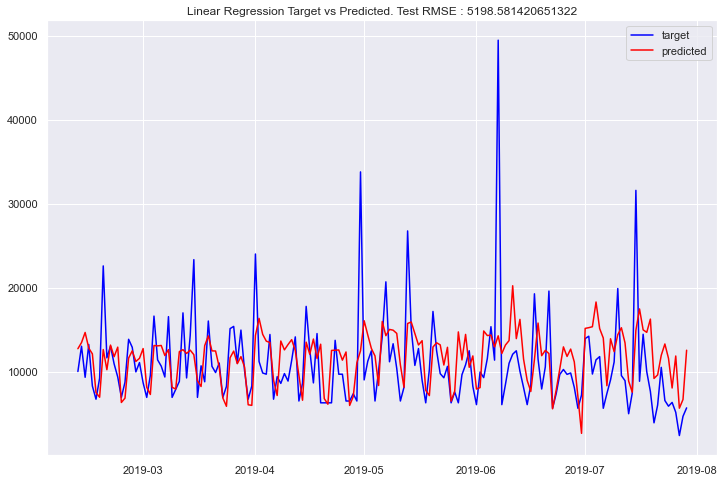

In [180]:
# testing of simple linear regression model for time series analysis
from sklearn.linear_model import Ridge

# machine learning in two lines
lr_model = Ridge(alpha=5)
lr_model.fit(X_train, y_train)

# cross validate using the right iterator for time series
cv_space = TimeSeriesSplit(n_splits=4)
cv_score = cross_val_score(lr_model, 
                           X_train, y_train, 
                           cv=cv_space, 
                           scoring=mape_scorer)

cv_score = np.mean(np.abs(cv_score))
# evaluate the model on the test set
predictions = lr_model.predict(X_test.values)
test_score = mean_squared_error(y_test.values, predictions, squared=False)
print(f"Linear Regression RMSE cross-validation/test: {round(cv_score, 4)}/{round(test_score, 4)}")

# plot
fig3, ax = plt.subplots(1, 1, figsize=(12, 8))

# print feature importance
# coeffs = pd.DataFrame(model.coef_, columns=X_train.columns).apply(np.abs)
# coeffs.plot(ax=ax1, kind="bar")
# ax1.grid(True, axis="y")
# ax1.get_legend().remove()

y = y_test_trf.inverse(y_test.index, y_test.values)
p = y_test_trf.inverse(y_test.index, predictions)

ax.plot(y, label="target", color="blue")
ax.plot(p, label="predicted", color="red")
ax.legend()
plt.title(f"Linear Regression Target vs Predicted. Test RMSE : {test_score}")
plt.show()

# save results for later comparison
forecasting_results["linear_revenue"] = {
    "predicted": predictions,
    "cv_score": cv_score,
    "test_score": test_score
}

fig3.savefig('report/images/Linear_Regression_Result.png')

In [185]:
# run XGBoost algorithm with hyperparameters optimization
# this model outperforms the linear regression

def train_xgb(params, X_train, y_train):
    """
    Train XGBoost regressor using the parameters given as input. The model
    is validated using standard cross validation technique adapted for time series
    data. This function returns a friendly output for the hyperopt parameter optimization
    module.
    
    Parameters
    ----------
    params: dict with the parameters of the XGBoost regressor. For complete list see: 
            https://xgboost.readthedocs.io/en/latest/parameter.html
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets    
    
    Returns
    -------
    dict with keys 'model' for the trained model, 'status' containing the hyperopt
    status string and 'loss' with the RMSE obtained from cross-validation
    """
    
    n_estimators = int(params["n_estimators"])
    max_depth= int(params["max_depth"])

    try:
        model = xgb.XGBRegressor(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=params["learning_rate"],
                                 subsample=params["subsample"])

        result = model.fit(X_train, 
                           y_train.values.ravel(),
                           eval_set=[(X_train, y_train.values.ravel())],
                           early_stopping_rounds=50,
                           verbose=False)
        
        # cross validate using the right iterator for time series
        cv_space = TimeSeriesSplit(n_splits=5)
        cv_score = cross_val_score(model, 
                                   X_train, y_train.values.ravel(), 
                                   cv=cv_space, 
                                   scoring=mape_scorer)

        rmse = np.abs(np.mean(np.array(cv_score)))
        return {
            "loss": rmse,
            "status": STATUS_OK,
            "model": model
        }
        
    except ValueError as ex:
        return {
            "error": ex,
            "status": STATUS_FAIL
        }
    
def optimize_xgb(X_train, y_train, max_evals=10):
    """
    Run Bayesan optimization to find the optimal XGBoost algorithm
    hyperparameters.
    
    Parameters
    ----------
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets
    max_evals: the maximum number of iterations in the Bayesian optimization method
    
    Returns
    -------
    best: dict with the best parameters obtained
    trials: a list of hyperopt Trials objects with the history of the optimization
    """
    
    space = {
        "n_estimators": hp.quniform("n_estimators", 100, 1000, 10),
        "max_depth": hp.quniform("max_depth", 1, 8, 1),
        "learning_rate": hp.loguniform("learning_rate", -5, 1),
        "subsample": hp.uniform("subsample", 0.8, 1),
        "gamma": hp.quniform("gamma", 0, 100, 1)
    }

    objective_fn = partial(train_xgb, 
                           X_train=X_train, 
                           y_train=y_train)
    
    trials = Trials()
    best = fmin(fn=objective_fn,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    # evaluate the best model on the test set
    print(f"""
    Best parameters:
        learning_rate: {best["learning_rate"]} 
        n_estimators: {best["n_estimators"]}
        max_depth: {best["max_depth"]}
        sub_sample: {best["subsample"]}
        gamma: {best["gamma"]}
    """)
    return best, trials

best, trials = optimize_xgb(X_train, y_train, max_evals=50)

100%|██████████| 50/50 [00:36<00:00,  1.37trial/s, best loss: 42.48648179267387] 

    Best parameters:
        learning_rate: 0.01010128965725817 
        n_estimators: 140.0
        max_depth: 5.0
        sub_sample: 0.832438241459936
        gamma: 11.0
    


In [186]:

# evaluate the best model on the test set
res = train_xgb(best, X_test, y_test)
xgb_model = res["model"]
predictions = xgb_model.predict(X_test)
cv_score = min([f["loss"] for f in trials.results if f["status"] == STATUS_OK])
test_score = mape(y_test.values, predictions)

print(f"Root mean square error cross-validation/test: {cv_score:.4f} / {test_score:.4f}")

Root mean square error cross-validation/test: 42.4865 / 23.8995


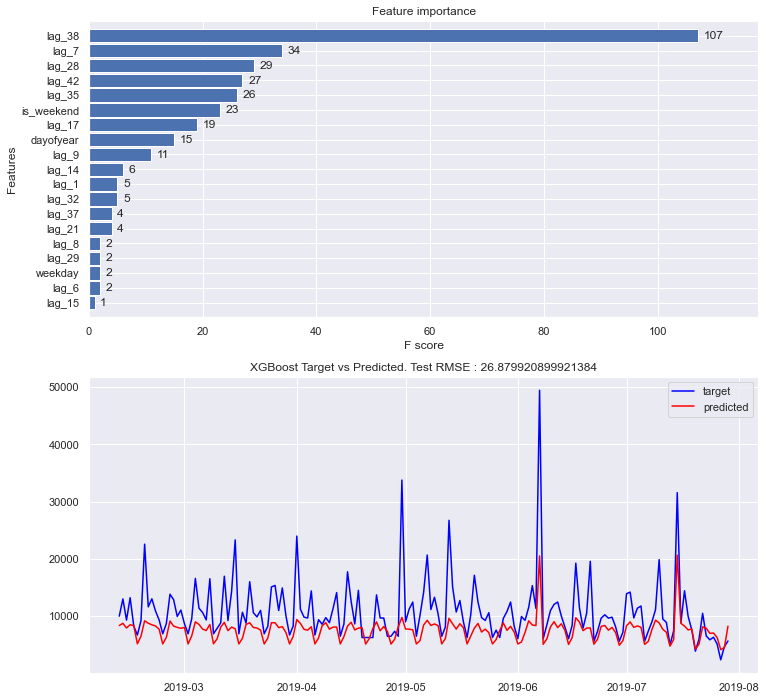

In [183]:
# inverse transform
actual = y_test
predictions = pd.Series(data=predictions, index=y_test.index)
# predictions = transformer.inverse(y_test.index, predictions)
# actual = transformer.inverse(y_test.index, y_test.values)

# plot predictions on the test set
fig4, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
_ = xgb.plot_importance(xgb_model, height=0.9, ax=ax1)
ax2.plot(actual, label="target", color="blue")
ax2.plot(predictions, label="predicted", color="red")
plt.title(f"XGBoost Target vs Predicted. Test RMSE : {test_score}")
ax2.legend()
plt.show()

fig4.savefig('report/images/XGBoost_Result.png')

# store the results
xgb_predictions = predictions.copy()
xgb_predictions = pd.DataFrame(xgb_predictions, columns = ['pred_price'])
xgb_predictions.to_csv('report/predictions/XGBoost_Prediction_Result.csv')

### Direct and Recursive Forecasting

In [188]:
# lags used in building the features for the one-step ahead model
feature_lags = [int(f.split("_")[1]) for f in features if "lag" in f]
# feature_lags = [1, 2, 29, 48]

# target series used for forecasting
fcast_trf = TargetTransformer(log=False, detrend=False)
y = fcast_trf.transform(target.index, target.values)

In [201]:
def forecast_multi_recursive(y, model, lags, n_steps=FCAST_STEPS, step="1D"):
    
    """Multi-step recursive forecasting using the input time 
    series data and a pre-trained machine learning model
    
    Parameters
    ----------
    y: pd.Series holding the input time-series to forecast
    model: an already trained machine learning model implementing the scikit-learn interface
    lags: list of lags used for training the model
    n_steps: number of time periods in the forecasting horizon
    step: forecasting time period given as Pandas time series frequencies
    
    Returns
    -------
    fcast_values: pd.Series with forecasted values indexed by forecast horizon dates 
    """
    
    # get the dates to forecast
    last_date = y.index[-1] + pd.Timedelta(hours=1)
    fcast_range = pd.date_range(last_date, periods=n_steps, freq=step)

    fcasted_values = []
    target = y.copy()

    for date in fcast_range:

        new_point = fcasted_values[-1] if len(fcasted_values) > 0 else 0.0   
        target = target.append(pd.Series(index=[date], data=new_point))

        # forecast
        ts_features = create_ts_features(target)
        if len(lags) > 0:
            lags_features = create_lag_features(target, lags=lags)
            features = ts_features.join(lags_features, how="outer").dropna()
        else:
            features = ts_features
            
        predictions = model.predict(features)
        fcasted_values.append(predictions[-1])

    return pd.Series(index=fcast_range, data=fcasted_values)

rec_fcast = forecast_multi_recursive(y, xgb_model, feature_lags)

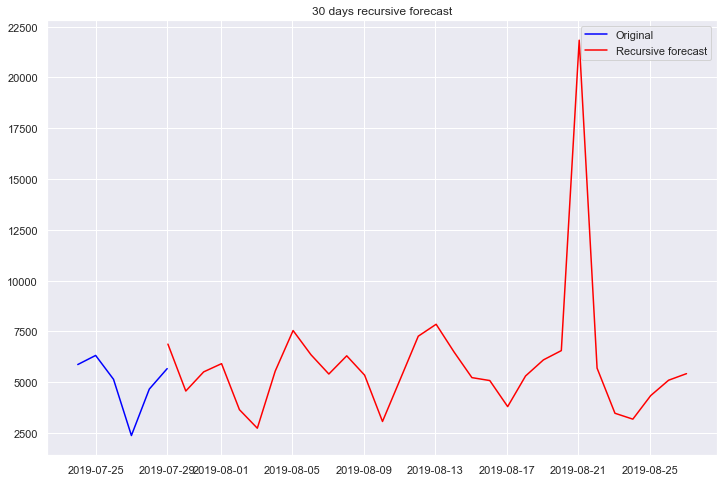

The forecasted revenue for  on the 2019-08-01 00:00:00 is : 5916.95


In [262]:
y = fcast_trf.inverse(index=y.index, values=y.values)
rec_fcast = fcast_trf.inverse(index=rec_fcast.index, values=rec_fcast.values)

# plot resulting forecast
start_date = y.index[-1] - pd.Timedelta(days=5)
in_sample = y[y.index >= start_date]

fig5, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(in_sample, color="blue", label="Original")
ax.plot(rec_fcast, color="red", label="Recursive forecast")
ax.set_title(f"{FCAST_STEPS} days recursive forecast")
ax.legend()
plt.show()

fig5.savefig('report/images/Recursive_Forecast_Result.png')

rec_fcast_df = pd.DataFrame(rec_fcast).reset_index()
rec_fcast_df.columns = ['date', 'forecasted_price']
rec_fcast_df.to_csv('report/predictions/XGBoost_Forecast_Result.csv')
rec_fcast_df['date'] = pd.to_datetime(rec_fcast_df['date'])
rec_fcast_df['date'] = rec_fcast_df['date'].dt.date
rec_fcast_df['date'] = pd.to_datetime(rec_fcast_df['date'])
rec_fcast_df = rec_fcast_df.set_index('date')
rec_fcast_on_date = rec_fcast_df.loc[date_input][0]
print(f'The forecasted revenue for {country} on the {date_input} is : {round(rec_fcast_on_date,2)}')

### Direct Forecasting - Revenue

This takes a while, skip this process if only using recursive forecasting

In [142]:
def forecast_multi_direct(y, lags, n_steps=FCAST_STEPS, step="1D", pretrained_m=None, n_evals=25):
    
    """Multi-step direct forecasting using a XGBoost based machine learning model
    to forecast each time period ahead
    
    Parameters
    ----------
    y: pd.Series holding the input time-series to forecast
    lags: list of lags used for training the model
    n_steps: how many steps forecast into the future
    step: the period of forecasting
    pretrained_m: a pretrained one-step ahead model to be used for the first step
                  it must implement the scikit-learn model interface
    n_evals: the number of evaluation in model optimization at each step
    
    Returns
    -------
    fcast_values: pd.Series with forecasted values indexed by forecast horizon dates    
    """
    
    def one_step_features(date, step):

        # features must be obtained using data lagged 
        # by the desired number of steps (the for loop index)
        tmp = y[y.index <= date]       
        lags_features = create_lag_features(tmp, lags=lags)
        ts_features = create_ts_features(tmp)
        features = ts_features.join(lags_features, how="outer").dropna()
        
        # build target to be ahead of the features built 
        # by the desired number of steps (the for loop index)
        target = y[y.index >= features.index[0] + pd.Timedelta(hours=step)]
        assert len(features.index) == len(target.index)
        
        return features, target
        
    fcast_values = []
    fcast_range = pd.date_range(y.index[-1] + pd.Timedelta(hours=1), 
                                periods=n_steps, freq=step)
    fcast_features, _ = one_step_features(y.index[-1], 0)
            
    for s in range(1, n_steps+1):
        
        last_date = y.index[-1] - pd.Timedelta(hours=s)
        features, target = one_step_features(last_date, s)
        
        # train XGBoost model for the current forecasting step
        X_train, X_test, y_train, y_test = train_test_split(features, 
                                                            target, 
                                                            test_size=0.2,
                                                            shuffle=False) 

        y_train_trf = TargetTransformer(log=False, detrend=False)
        y_train = y_train_trf.transform(y_train.index, y_train.values)

        y_test_trf = TargetTransformer(log=False, detrend=False)
        y_test = y_test_trf.transform(y_test.index, y_test.values)        
        
        # use the pretrained model to save one model training
        if s == 1 and pretrained_m is not None:
            model = pretrained_m
        else:
            best, trials = optimize_xgb(X_train, y_train, max_evals=n_evals)
            res = train_xgb(best, X_test, y_test)
            model = res["model"]
                
        # use the model to predict s steps ahead
        predictions = model.predict(fcast_features)        
        fcast_values.append(predictions[-1])
                
    return pd.Series(index=fcast_range, data=fcast_values)
        
dir_fcast = forecast_multi_direct(y, feature_lags, n_evals=25)

100%|██████████| 25/25 [00:19<00:00,  1.26trial/s, best loss: 48.39070460112362] 

    Best parameters:
        learning_rate: 0.006855684054547524 
        n_estimators: 110.0
        max_depth: 3.0
        sub_sample: 0.8066681717905149
        gamma: 99.0
    
100%|██████████| 25/25 [00:23<00:00,  1.07trial/s, best loss: 49.671707981353954]

    Best parameters:
        learning_rate: 0.009112705027468611 
        n_estimators: 100.0
        max_depth: 5.0
        sub_sample: 0.8005770582459951
        gamma: 22.0
    
100%|██████████| 25/25 [00:29<00:00,  1.16s/trial, best loss: 73.74724288458506] 

    Best parameters:
        learning_rate: 0.007181165698337455 
        n_estimators: 290.0
        max_depth: 2.0
        sub_sample: 0.8032229533809393
        gamma: 43.0
    
100%|██████████| 25/25 [00:35<00:00,  1.41s/trial, best loss: 104.3137994742581] 

    Best parameters:
        learning_rate: 0.0072522543852384614 
        n_estimators: 850.0
        max_depth: 1.0
       

100%|██████████| 25/25 [00:27<00:00,  1.09s/trial, best loss: 42.89386170625717] 

    Best parameters:
        learning_rate: 0.007165763642684699 
        n_estimators: 120.0
        max_depth: 6.0
        sub_sample: 0.8077896401994658
        gamma: 56.0
    
100%|██████████| 25/25 [00:26<00:00,  1.08s/trial, best loss: 55.39168282729618]

    Best parameters:
        learning_rate: 0.011579397713593575 
        n_estimators: 190.0
        max_depth: 4.0
        sub_sample: 0.9077541471993567
        gamma: 37.0
    
100%|██████████| 25/25 [00:32<00:00,  1.30s/trial, best loss: 63.849779380515386]

    Best parameters:
        learning_rate: 0.007057755221038317 
        n_estimators: 410.0
        max_depth: 2.0
        sub_sample: 0.9934087941098463
        gamma: 100.0
    
100%|██████████| 25/25 [01:14<00:00,  2.98s/trial, best loss: 74.0427415496277]

    Best parameters:
        learning_rate: 0.5656293250584004 
        n_estimators: 890.0
        max_depth: 8.0
        sub_

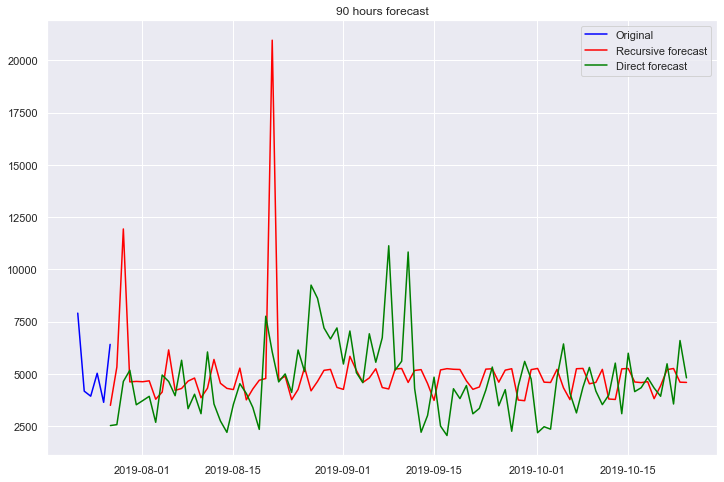

In [144]:
y = fcast_trf.inverse(index=y.index, values=y.values)
rec_fcast = fcast_trf.inverse(index=rec_fcast.index, values=rec_fcast.values)
dir_fcast = fcast_trf.inverse(index=dir_fcast.index, values=dir_fcast.values)

# plot resulting forecast
start_date = y.index[-1] - pd.Timedelta(days=5)
in_sample = y[y.index >= start_date]

fig5, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(in_sample, color="blue", label="Original")
ax.plot(rec_fcast, color="red", label="Recursive forecast")
ax.plot(dir_fcast, color="green", label="Direct forecast")
ax.set_title(f"{FCAST_STEPS} days forecast")
ax.legend()
plt.show()

fig5.savefig('report/images/Forecast_Results.png')

### XGBoost Method - Times Viewed

In [145]:
# 1 day forecast
FCAST_STEPS = 30
# seasonal period inferred from the autocorrelation function
SEASONAL_PERIOD = 5

# the complete time series
c_target = ts2["y"]

# data used for training
date = c_target.index[-1] - pd.Timedelta(hours=FCAST_STEPS)
t_target = c_target[c_target.index <= date]

# data used for forecasting
f_target = c_target[c_target.index > date]
fcast_initial_date = f_target.index[0]
fcast_range = pd.date_range(fcast_initial_date, periods=FCAST_STEPS, freq="D")

print(f"Full available time range: from {c_target.index[0]} to {c_target.index[-1]}")
print(f"Training time range: from {t_target.index[0]} to {t_target.index[-1]}")
print(f"Short forecasting time range: from {fcast_range[0]} to {fcast_range[-1]}")

Full available time range: from 2017-11-28 00:00:00 to 2019-07-31 00:00:00
Training time range: from 2017-11-28 00:00:00 to 2019-07-27 00:00:00
Short forecasting time range: from 2019-07-28 00:00:00 to 2019-10-25 00:00:00


In [146]:
lags = create_lag_features(t_target, thres=0.05)
ts = create_ts_features(t_target)
features = ts.join(lags, how="outer").dropna()
target = t_target[t_target.index >= features.index[0]]
features.head()

,hour,weekday,dayofyear,is_weekend,weekofyear,month,season,shift,lag_1,lag_2,...,lag_22,lag_28,lag_29,lag_30,lag_31,lag_33,lag_35,lag_38,lag_40,lag_48
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-15,0,3,15,0,3,1,1,1,5700.0,6977.756137,...,6977.756137,3212.000000,4013.000000,6977.756137,8973.000000,14280.000000,17017.0,7922.000000,10510.000000,15047.0
2018-01-16,0,3,16,0,3,1,1,1,6112.0,5700.000000,...,6977.756137,5218.000000,3212.000000,4013.000000,6977.756137,9505.000000,11127.0,6977.756137,11985.000000,14159.0
2018-01-17,0,3,17,0,3,1,1,1,8924.0,6112.000000,...,6977.756137,3028.000000,5218.000000,3212.000000,4013.000000,8973.000000,14280.0,8521.000000,7922.000000,15766.0
2018-01-18,0,3,18,0,3,1,1,1,5168.0,8924.000000,...,6977.756137,6977.756137,3028.000000,5218.000000,3212.000000,6977.756137,9505.0,17017.000000,6977.756137,12524.0
2018-01-19,0,3,19,0,3,1,1,1,7288.0,5168.000000,...,6977.756137,6977.756137,6977.756137,3028.000000,5218.000000,4013.000000,8973.0,11127.000000,8521.000000,3313.0


In [147]:

X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.3,
                                                    shuffle=False) 

y_train_trf = TargetTransformer(log=False, detrend=False)
y_train = y_train_trf.transform(y_train.index, y_train.values)

y_test_trf = TargetTransformer(log=False, detrend=False)
y_test = y_test_trf.transform(y_test.index, y_test.values)

Linear Regression RMSE cross-validation/test: 29.3025/1585.303


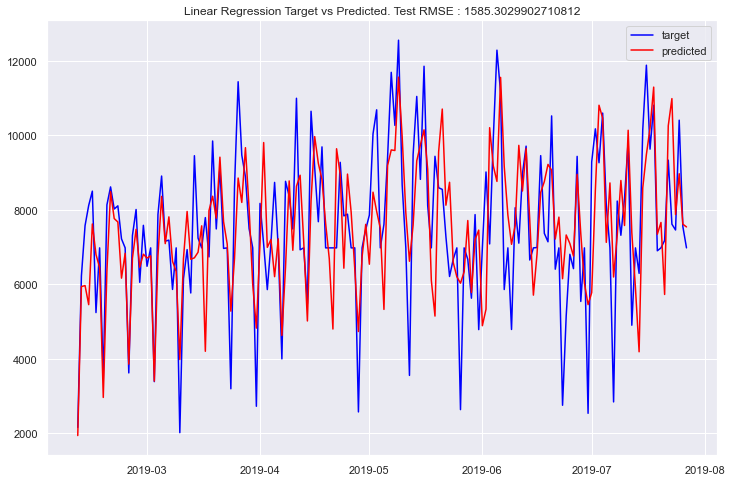

In [148]:
# machine learning in two lines
lr_model = Ridge(alpha=5)
lr_model.fit(X_train, y_train)

# cross validate using the right iterator for time series
cv_space = TimeSeriesSplit(n_splits=4)
cv_score = cross_val_score(lr_model, 
                           X_train, y_train, 
                           cv=cv_space, 
                           scoring=mape_scorer)

cv_score = np.mean(np.abs(cv_score))
# evaluate the model on the test set
predictions = lr_model.predict(X_test.values)
test_score = mean_squared_error(y_test.values, predictions, squared=False)
print(f"Linear Regression RMSE cross-validation/test: {round(cv_score, 4)}/{round(test_score, 4)}")

# plot
fig6, ax = plt.subplots(1, 1, figsize=(12, 8))

# print feature importance
# coeffs = pd.DataFrame(model.coef_, columns=X_train.columns).apply(np.abs)
# coeffs.plot(ax=ax1, kind="bar")
# ax1.grid(True, axis="y")
# ax1.get_legend().remove()

y = y_test_trf.inverse(y_test.index, y_test.values)
p = y_test_trf.inverse(y_test.index, predictions)

ax.plot(y, label="target", color="blue")
ax.plot(p, label="predicted", color="red")
ax.legend()
plt.title(f"Linear Regression Target vs Predicted. Test RMSE : {test_score}")
plt.show()

# save results for later comparison
forecasting_results["linear"] = {
    "predicted": predictions,
    "cv_score": cv_score,
    "test_score": test_score
}

fig6.savefig('report/images/Linear_Regression_Result_Times_Viewed.png')

In [149]:
best, trials = optimize_xgb(X_train, y_train, max_evals=50)

100%|██████████| 50/50 [01:00<00:00,  1.21s/trial, best loss: 31.919900701824908]

    Best parameters:
        learning_rate: 0.006770868450368139 
        n_estimators: 500.0
        max_depth: 5.0
        sub_sample: 0.9523528675717499
        gamma: 80.0
    


In [150]:

# evaluate the best model on the test set
res = train_xgb(best, X_test, y_test)
xgb_model = res["model"]
predictions = xgb_model.predict(X_test)
cv_score = min([f["loss"] for f in trials.results if f["status"] == STATUS_OK])
test_score = mape(y_test.values, predictions)

print(f"Root mean square error cross-validation/test: {cv_score:.4f} / {test_score:.4f}")

Root mean square error cross-validation/test: 31.9199 / 4.4618


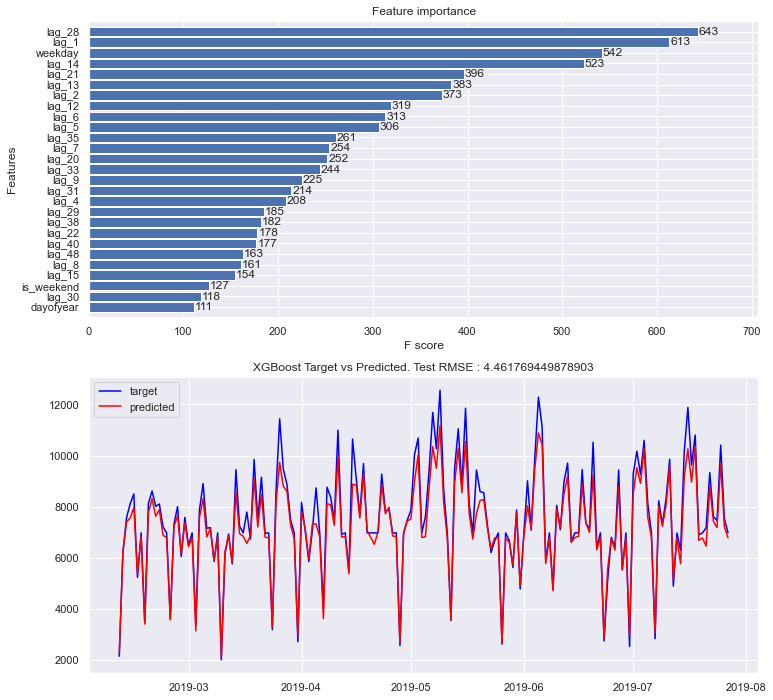

In [151]:
# inverse transform
actual = y_test
predictions = pd.Series(data=predictions, index=y_test.index)
# predictions = transformer.inverse(y_test.index, predictions)
# actual = transformer.inverse(y_test.index, y_test.values)

# plot predictions on the test set
fig7, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
_ = xgb.plot_importance(xgb_model, height=0.9, ax=ax1)
ax2.plot(actual, label="target", color="blue")
ax2.plot(predictions, label="predicted", color="red")
plt.title(f"XGBoost Target vs Predicted. Test RMSE : {test_score}")
ax2.legend()
plt.show()

fig7.savefig('report/images/XGBoost_Result_Times_Viewed.png')

# store the results
xgb_predictions = predictions.copy()

In [152]:
# lags used in building the features for the one-step ahead model
feature_lags = [int(f.split("_")[1]) for f in features if "lag" in f]
# feature_lags = [1, 2, 29, 48]

# target series used for forecasting
fcast_trf = TargetTransformer(log=False, detrend=False)
y = fcast_trf.transform(target.index, target.values)

In [153]:
rec_fcast = forecast_multi_recursive(y, xgb_model, feature_lags)

In [154]:
dir_fcast = forecast_multi_direct(y, feature_lags, n_evals=25)

100%|██████████| 25/25 [00:42<00:00,  1.71s/trial, best loss: 28.648884620042537]

    Best parameters:
        learning_rate: 0.04712617535222325 
        n_estimators: 670.0
        max_depth: 8.0
        sub_sample: 0.8705385679815191
        gamma: 39.0
    
100%|██████████| 25/25 [00:39<00:00,  1.57s/trial, best loss: 28.48599865276425]

    Best parameters:
        learning_rate: 0.04879245882148766 
        n_estimators: 670.0
        max_depth: 7.0
        sub_sample: 0.9332228785053127
        gamma: 44.0
    
100%|██████████| 25/25 [00:39<00:00,  1.58s/trial, best loss: 27.576543452317395]

    Best parameters:
        learning_rate: 0.027364614638112475 
        n_estimators: 490.0
        max_depth: 8.0
        sub_sample: 0.9059948725531412
        gamma: 53.0
    
100%|██████████| 25/25 [00:30<00:00,  1.24s/trial, best loss: 29.11328811138548]

    Best parameters:
        learning_rate: 0.01902832819854056 
        n_estimators: 1000.0
        max_depth: 6.0
        sub_

100%|██████████| 25/25 [00:47<00:00,  1.90s/trial, best loss: 34.79034226032885] 

    Best parameters:
        learning_rate: 0.011739216267817437 
        n_estimators: 130.0
        max_depth: 1.0
        sub_sample: 0.9243343400783038
        gamma: 82.0
    
100%|██████████| 25/25 [00:59<00:00,  2.37s/trial, best loss: 33.251961967440664]

    Best parameters:
        learning_rate: 0.01289642066920615 
        n_estimators: 200.0
        max_depth: 6.0
        sub_sample: 0.992076398434941
        gamma: 78.0
    
100%|██████████| 25/25 [00:50<00:00,  2.03s/trial, best loss: 35.63882719378351]

    Best parameters:
        learning_rate: 0.23357365964291982 
        n_estimators: 960.0
        max_depth: 6.0
        sub_sample: 0.9479791425800527
        gamma: 16.0
    
100%|██████████| 25/25 [01:05<00:00,  2.63s/trial, best loss: 33.491581357790345]

    Best parameters:
        learning_rate: 0.014259558589059597 
        n_estimators: 160.0
        max_depth: 4.0
        sub_

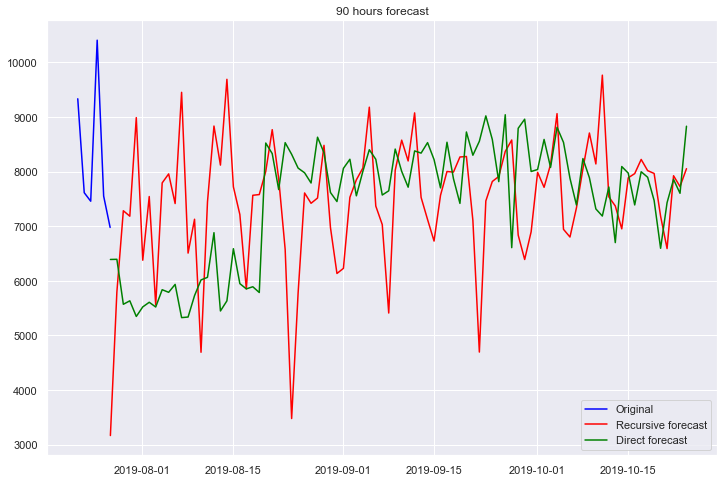

In [155]:
y = fcast_trf.inverse(index=y.index, values=y.values)
rec_fcast = fcast_trf.inverse(index=rec_fcast.index, values=rec_fcast.values)
dir_fcast = fcast_trf.inverse(index=dir_fcast.index, values=dir_fcast.values)

# plot resulting forecast
start_date = y.index[-1] - pd.Timedelta(days=5)
in_sample = y[y.index >= start_date]

fig8, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(in_sample, color="blue", label="Original")
ax.plot(rec_fcast, color="red", label="Recursive forecast")
ax.plot(dir_fcast, color="green", label="Direct forecast")
ax.set_title(f"{FCAST_STEPS} days forecast")
ax.legend()
plt.show()

fig8.savefig('report/images/Forecast_Results_Times_Viewed.png')

In [266]:
r = requests.get('http://127.0.0.1:8080/logs/train-test.log')
print(r.text)

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8080): Max retries exceeded with url: /logs/train-test.log (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x13b11b910>: Failed to establish a new connection: [Errno 61] Connection refused'))